#SCC5920 - Projeto Final (Mineração de Imagens)

#Análise Comparativa de Representações de Imagens em Classificação de Figuras Sintéticas

Ada Maris Pereira Mário - 12725432

##Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


!pip install mahotas
import mahotas as mt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.8 MB/s eta 0:00:00


## Dados

In [ ]:
# Para carregar os dados diretamente do kaggle precisa do arquivo json da sua conta
# Do contrário, fazer o processo manual usual a partir de:
# https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

# Carregar o arquivo kaggle.json para o Google Colab
from google.colab import files
files.upload()  # Selecione o arquivo kaggle.json que foi baixado

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 92% 96.0M/105M [00:00<00:00, 110MB/s]
100% 105M/105M [00:01<00:00, 110MB/s] 


In [ ]:
# Descompactar o arquivo baixado
!unzip cifake-real-and-ai-generated-synthetic-images.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  in

In [ ]:
def load_images_labels(directory):
  image_files = []
  labels = []
  for label in ['REAL', 'FAKE']:
    for img_file in os.listdir(os.path.join(directory, label)):
      if img_file.endswith('.jpg') or img_file.endswith('.png'):
        image_files.append(os.path.join(directory, label, img_file))
        labels.append(0 if label == 'REAL' else 1)
  return pd.DataFrame({'image_path': image_files, 'label': labels})

img_train = load_images_labels("/content/train/")
img_test = load_images_labels("/content/test/")

In [ ]:
img_train

,image_path,label
0,/content/train/REAL/2418 (5).jpg,0
1,/content/train/REAL/0515 (10).jpg,0
2,/content/train/REAL/0658 (7).jpg,0
3,/content/train/REAL/0366.jpg,0
4,/content/train/REAL/3188 (3).jpg,0
...,...,...
99995,/content/train/FAKE/2872 (3).jpg,1
99996,/content/train/FAKE/4297 (10).jpg,1
99997,/content/train/FAKE/1274.jpg,1
99998,/content/train/FAKE/3270 (4).jpg,1


In [ ]:
img_test

,image_path,label
0,/content/test/REAL/0515 (10).jpg,0
1,/content/test/REAL/0658 (7).jpg,0
2,/content/test/REAL/0366.jpg,0
3,/content/test/REAL/0753 (8).jpg,0
4,/content/test/REAL/0731 (5).jpg,0
...,...,...
19995,/content/test/FAKE/614 (10).jpg,1
19996,/content/test/FAKE/970 (5).jpg,1
19997,/content/test/FAKE/221 (9).jpg,1
19998,/content/test/FAKE/156 (9).jpg,1


##Histograma de Cor

In [ ]:
def color_histogram(image, bins=(8, 8, 8)):
  image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
  hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
  hist = cv2.normalize(hist, hist).flatten()  # Normaliza e achata o histograma em um vetor
  return hist

img_train['color_hist'] = img_train['image_path'].apply(lambda x: color_histogram(Image.open(x)))
img_test['color_hist'] = img_test['image_path'].apply(lambda x: color_histogram(Image.open(x)))

##Textura

In [ ]:
def haralick_features(image_path):
  try:
    img = Image.open(image_path).convert('L')  # Converte para tons de cinza
    img = np.array(img)

    haralick_textures = mt.features.haralick(img)
    haralick_mean = haralick_textures.mean(axis=0)

    return haralick_mean
  except Exception as e:
    print(f"Erro ao processar {image_path}: {e}")
    return None

img_train['haralick_features'] = img_train['image_path'].apply(haralick_features)
img_test['haralick_features'] = img_test['image_path'].apply(haralick_features)

##Resnet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()  # Coloca o modelo em modo de avaliação para desativar camadas de dropout

# Captura a saída da penúltima camada (antes da camada de classificação final)
layer = model._modules.get('avgpool')

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def resnet_embeddings(image_path):
  img = Image.open(image_path).convert('RGB')
  img_transformada = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device)

  embedding = torch.zeros(512).to(device)

  def capturar_embedding(m, i, o):
    embedding.copy_(o.data.reshape(o.data.size(1)))

  h = layer.register_forward_hook(capturar_embedding)
  model(img_transformada)
  h.remove()

  return embedding.cpu().numpy()

img_train['resnet_embedding'] = img_train['image_path'].apply(lambda x: resnet_embeddings(x))
img_test['resnet_embedding'] = img_test['image_path'].apply(lambda x: resnet_embeddings(x))

Usando dispositivo: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


##Dataframes finais

In [ ]:
img_train

,image_path,label,color_hist,haralick_features,resnet_embedding
0,/content/train/REAL/1910 (3).jpg,0,"[0.003141301, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0007952010703549917, 350.56880853277835, 0....","[0.51195, 0.017228229, 0.25951517, 1.0351559, ..."
1,/content/train/REAL/4677 (6).jpg,0,"[0.013939208, 0.041817624, 0.0, 0.0, 0.0, 0.0,...","[0.0008603664976977374, 686.8011186264308, 0.7...","[0.019052686, 0.5500937, 0.1364709, 0.0, 0.153..."
2,/content/train/REAL/0087 (2).jpg,0,"[0.08840532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0007319601728821677, 1050.5902624219566, 0....","[0.04712813, 1.9154227, 0.694355, 0.1484065, 0..."
3,/content/train/REAL/0056 (6).jpg,0,"[0.19052467, 0.15542802, 0.005013807, 0.0, 0.0...","[0.0005895190553750944, 1446.9582466181064, 0....","[0.0, 0.43301734, 1.1724551, 0.110457405, 0.11..."
4,/content/train/REAL/2984 (7).jpg,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00065289530439921, 548.1956539412071, 0.856...","[0.2663688, 0.36083746, 0.1677618, 1.9016584, ..."
...,...,...,...,...,...
99995,/content/train/FAKE/5797 (6).jpg,1,"[0.35568732, 0.3056688, 0.033345684, 0.0, 0.0,...","[0.0006947839659388502, 566.8386771592092, 0.9...","[0.023281034, 0.8792184, 0.7932264, 0.54881203..."
99996,/content/train/FAKE/5222 (8).jpg,1,"[0.4731508, 0.08525239, 0.0, 0.0, 0.0, 0.0, 0....","[0.000594404268250262, 2230.1845977497396, 0.7...","[0.07922894, 0.089356564, 0.7105553, 0.2256854..."
99997,/content/train/FAKE/1066.jpg,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0008098237963474168, 309.3974538241415, 0.9...","[0.5459773, 0.032943167, 0.015550793, 1.432349..."
99998,/content/train/FAKE/3538 (7).jpg,1,"[0.21391219, 0.020971783, 0.0, 0.0, 0.0, 0.0, ...","[0.0007090106829003482, 882.4187938995838, 0.7...","[0.23183632, 0.50483346, 0.80842197, 0.5204203..."


In [ ]:
img_test

,image_path,label,color_hist,haralick_features,resnet_embedding
0,/content/test/REAL/0087 (2).jpg,0,"[0.25889233, 0.009588605, 0.0, 0.0, 0.0, 0.0, ...","[0.0006429792171161379, 971.5320385665973, 0.6...","[0.27912474, 0.5447845, 0.50192374, 0.00028192..."
1,/content/test/REAL/0056 (6).jpg,0,"[0.08289388, 0.13355125, 0.036841724, 0.0, 0.0...","[0.0006956544984747913, 1039.4040956685744, 0....","[1.0858691, 1.3036649, 0.92447925, 1.10696, 0...."
2,/content/test/REAL/0758 (2).jpg,0,"[0.008340577, 0.0041702883, 0.0, 0.0, 0.0, 0.0...","[0.0006948610264411964, 1023.0303232310093, 0....","[0.036999002, 1.4926215, 0.61012614, 0.0140962..."
3,/content/test/REAL/0281 (7).jpg,0,"[0.01974292, 0.0043873154, 0.0, 0.0, 0.0, 0.0,...","[0.0020890508701294423, 250.20382414151925, 0....","[0.52390337, 0.28416333, 0.04861029, 0.3593214..."
4,/content/test/REAL/0410 (2).jpg,0,"[0.2661922, 0.048739415, 0.0, 0.0, 0.0, 0.0, 0...","[0.0006152341317901817, 1210.7012389438087, 0....","[0.23264796, 1.2119875, 1.0944269, 0.06259271,..."
...,...,...,...,...,...
19995,/content/test/FAKE/955 (7).jpg,1,"[0.24897873, 0.1908837, 0.0, 0.0, 0.0, 0.0, 0....","[0.00405228731834299, 1369.0080563865765, 0.64...","[0.074970745, 0.5961002, 0.8417626, 0.2702445,..."
19996,/content/test/FAKE/71 (9).jpg,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0029031530444184536, 275.39704734651406, 0....","[1.1433134, 0.03124494, 0.0, 0.046198513, 0.30..."
19997,/content/test/FAKE/652 (8).jpg,1,"[0.18902723, 0.27093905, 0.113416344, 0.056708...","[0.0006157275569278475, 1394.4156640218523, 0....","[0.28058067, 1.2365016, 0.11314314, 0.6511084,..."
19998,/content/test/FAKE/25 (9).jpg,1,"[0.49598715, 0.18291725, 0.0, 0.0, 0.0, 0.0, 0...","[0.0011143243399023275, 648.8871861992716, 0.9...","[0.254178, 0.16629444, 0.0637426, 0.008981216,..."


##Padronização

In [ ]:
scaler = StandardScaler().fit(img_train.color_hist.to_list())
color_train = scaler.transform(img_train.color_hist.to_list())
color_test = scaler.transform(img_test.color_hist.to_list())

scaler = StandardScaler().fit(img_train.haralick_features.to_list())
haralick_train = scaler.transform(img_train.haralick_features.to_list())
haralick_test = scaler.transform(img_test.haralick_features.to_list())

scaler = StandardScaler().fit(img_train.resnet_embedding.to_list())
resnet_train = scaler.transform(img_train.resnet_embedding.to_list())
resnet_test = scaler.transform(img_test.resnet_embedding.to_list())

##EDA

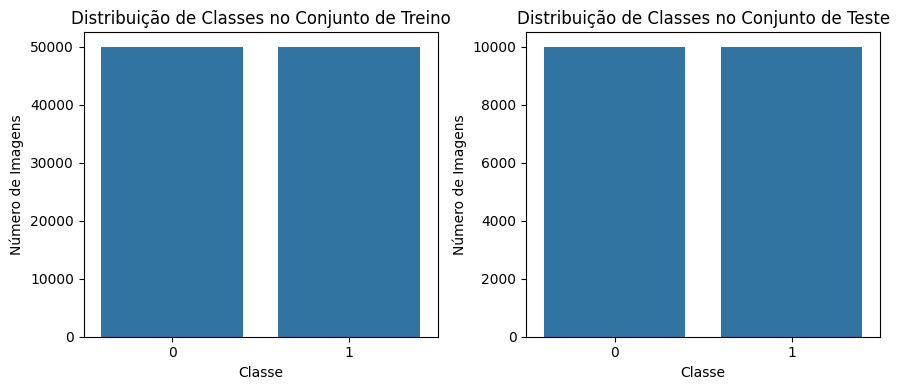

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

sns.countplot(x='label', data=img_train, ax=axs[0])
axs[0].set_title('Distribuição de Classes no Conjunto de Treino')
axs[0].set_xlabel('Classe')
axs[0].set_ylabel('Número de Imagens')

sns.countplot(x='label', data=img_test, ax=axs[1])
axs[1].set_title('Distribuição de Classes no Conjunto de Teste')
axs[1].set_xlabel('Classe')
axs[1].set_ylabel('Número de Imagens')

plt.tight_layout()
plt.show()

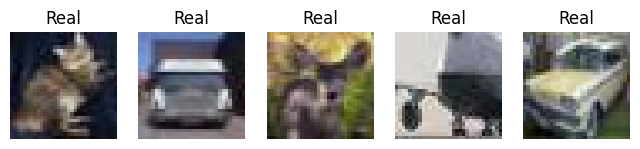

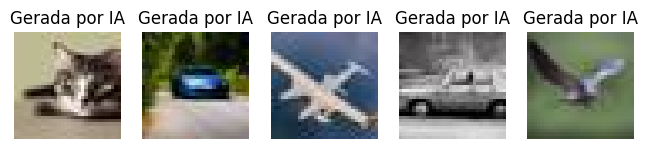

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))
real_images = img_train[img_train['label'] == 0]['image_path'].sample(5).values
for i, img_path in enumerate(real_images):
  img = Image.open(img_path)
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title('Real')

plt.show()

fig, axes = plt.subplots(1, 5, figsize=(8,4))
fake_images = img_train[img_train['label'] == 1]['image_path'].sample(5).values
for i, img_path in enumerate(fake_images):
  img = Image.open(img_path)
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title('Gerada por IA')

plt.show()


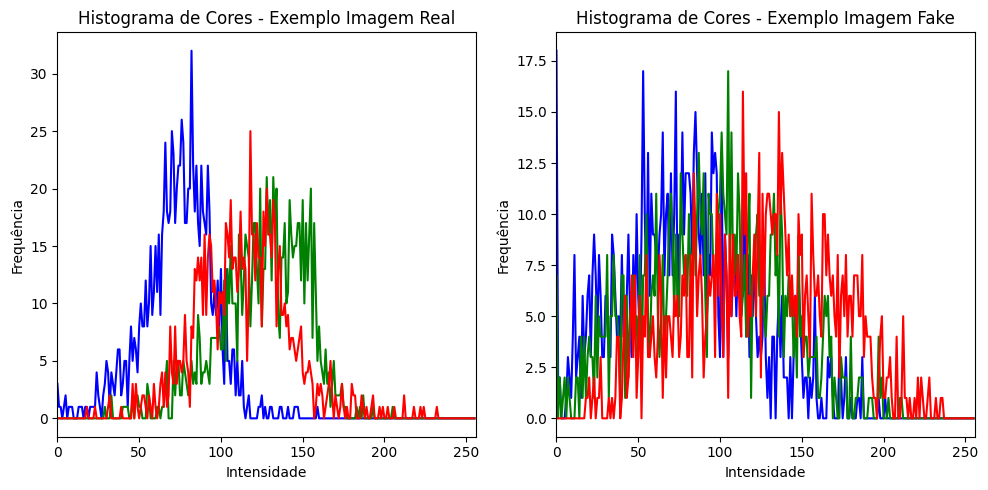

In [ ]:
def colorhist(image, ax, label):
  chans = cv2.split(image)
  colors = ('b', 'g', 'r')
  for (chan, color) in zip(chans, colors):
    # Calcular o histograma para cada canal
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    ax.plot(hist, color=color)
    ax.set_xlim([0, 256])
    ax.set_title(f"Histograma de Cores - {label}")
    ax.set_xlabel('Intensidade')
    ax.set_ylabel('Frequência')


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

real_path = img_train[img_train['label'] == 0]['image_path'].values[0]
real_image = cv2.imread(real_path)
colorhist(real_image, axs[0], 'Exemplo Imagem Real')

fake_path = img_train[img_train['label'] == 1]['image_path'].values[0]
fake_image = cv2.imread(fake_path)
colorhist(fake_image, axs[1], 'Exemplo Imagem Fake')

plt.tight_layout()
plt.show()

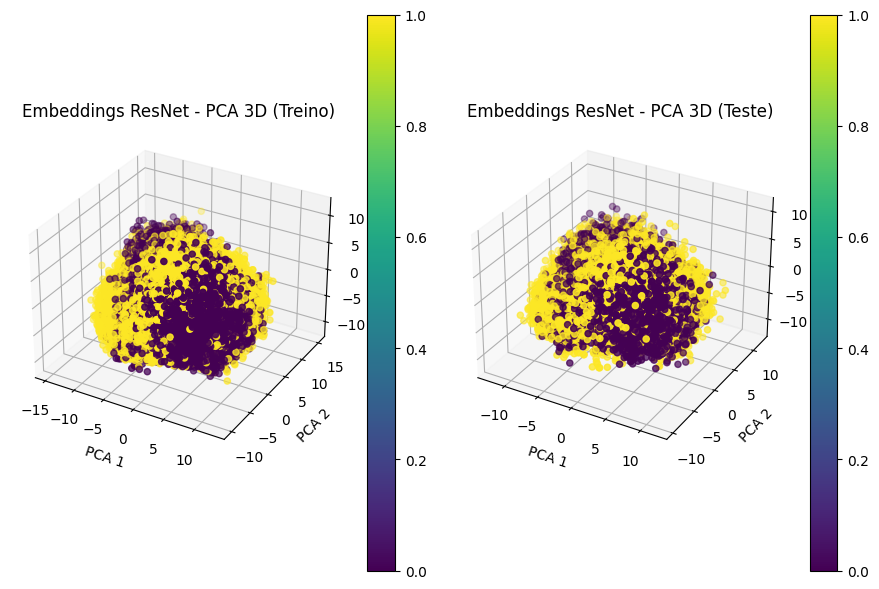

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))

resnet_embeddings_train = np.stack(img_train['resnet_embedding'].values)
pca_train = PCA(n_components=3).fit_transform(resnet_embeddings_train)
df_pca_train = pd.DataFrame({'pca_1': pca_train[:, 0], 'pca_2': pca_train[:, 1], 'pca_3': pca_train[:, 2], 'label': img_train['label']})

ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(df_pca_train['pca_1'], df_pca_train['pca_2'], df_pca_train['pca_3'], c=df_pca_train['label'], cmap='viridis')
ax.set_title('Embeddings ResNet - PCA 3D (Treino)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.colorbar(sc)

resnet_embeddings_test = np.stack(img_test['resnet_embedding'].values)
pca_test = PCA(n_components=3).fit_transform(resnet_embeddings_test)
df_pca_test = pd.DataFrame({'pca_1': pca_test[:, 0], 'pca_2': pca_test[:, 1], 'pca_3': pca_test[:, 2], 'label': img_test['label']})

ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(df_pca_test['pca_1'], df_pca_test['pca_2'], df_pca_test['pca_3'], c=df_pca_test['label'], cmap='viridis')
ax.set_title('Embeddings ResNet - PCA 3D (Teste)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.colorbar(sc)

plt.tight_layout()
plt.show()


##KNN

###Cores

In [ ]:
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'metric': ['euclidean','manhattan', 'cosine']}]

model = RandomizedSearchCV(knn, param_grid)

model.fit(color_train, img_train['label'])
print(model.best_params_)
model.score(color_train, img_train['label'])

Saída encontrada ao rodar o código acima no VS Code em outra máquina (Não consegui rodar no Colab): \
`{'n_neighbors': np.int64(8), 'metric': 'manhattan'}`

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8,metric="manhattan", weights='distance')
knn.fit(color_train, img_train['label'])
y_pred = knn.predict(color_test)
print(classification_report(img_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.78     10000
           1       0.79      0.74      0.76     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



In [ ]:
scores = cross_val_score(knn, color_test, img_test['label'])
print(scores)
print(scores.mean())

[0.72725 0.73425 0.724   0.735   0.73275]
0.73065


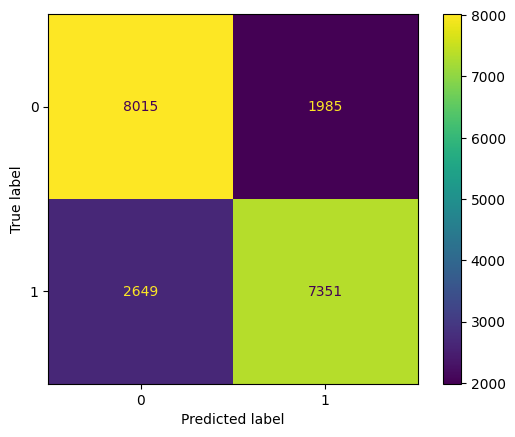

In [ ]:
cm = confusion_matrix(img_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

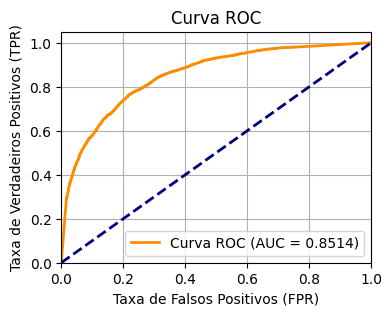

In [ ]:
y_score = knn.predict_proba(color_test)[:, 1]

fpr, tpr, thresholds = roc_curve(img_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
color_scores = [
    round(accuracy_score(img_test['label'], y_pred), 4),
    round(precision_score(img_test['label'], y_pred), 4),
    round(recall_score(img_test['label'], y_pred), 4),
    round(f1_score(img_test['label'], y_pred), 4),
    round(roc_auc_score(img_test['label'], knn.predict_proba(color_test)[:, 1]), 4)
]

###Textura

In [ ]:
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'metric': ['euclidean', 'minkowski','manhattan','chebyshev', 'cosine']}]

model = GridSearchCV(knn, param_grid)

model.fit(haralick_train, img_train['label'])
print(model.best_params_)
model.score(haralick_train, img_train['label'])

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


1.0

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20,metric="manhattan", weights='distance')
knn.fit(haralick_train, img_train['label'])
y_pred = knn.predict(haralick_test)
print(classification_report(img_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     10000
           1       0.82      0.84      0.83     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



In [ ]:
scores = cross_val_score(knn, haralick_test, img_test['label'])
print(scores)
print(scores.mean())

[0.8075  0.8045  0.79975 0.80075 0.802  ]
0.8029


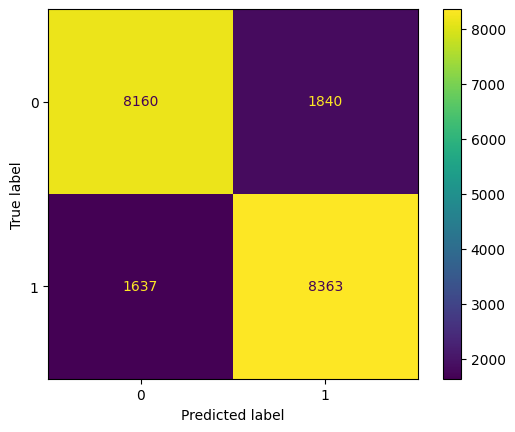

In [ ]:
cm = confusion_matrix(img_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

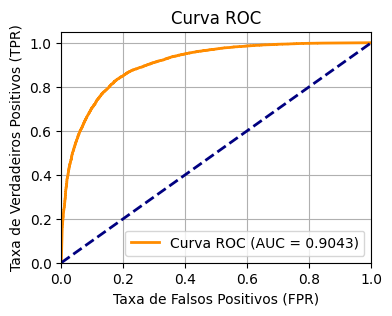

In [ ]:
y_score = knn.predict_proba(haralick_test)[:, 1]

fpr, tpr, thresholds = roc_curve(img_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
haralick_scores = [
    round(accuracy_score(img_test['label'], y_pred), 4),
    round(precision_score(img_test['label'], y_pred), 4),
    round(recall_score(img_test['label'], y_pred), 4),
    round(f1_score(img_test['label'], y_pred), 4),
    round(roc_auc_score(img_test['label'], knn.predict_proba(haralick_test)[:, 1]), 4)
]

###Resnet

In [ ]:
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'metric': ['euclidean','manhattan', 'cosine']}]

model = RandomizedSearchCV(knn, param_grid)

model.fit(resnet_train, img_train['label'])
print(model.best_params_)
model.score(resnet_train, img_train['label'])

Saída encontrada ao rodar o código acima no VS Code em outra máquina (Não consegui rodar no Colab): \
`{'n_neighbors': np.int64(13), 'metric': 'euclidean'}` \
`0.9115`

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13, metric="euclidean", weights='distance')
knn.fit(resnet_train, img_train['label'])
y_pred = knn.predict(resnet_test)
print(classification_report(img_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     10000
           1       0.92      0.91      0.91     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [ ]:
scores = cross_val_score(knn, resnet_test, img_test['label'])
print(scores)
print(scores.mean())

[0.8935  0.891   0.87825 0.88825 0.88475]
0.8871500000000001


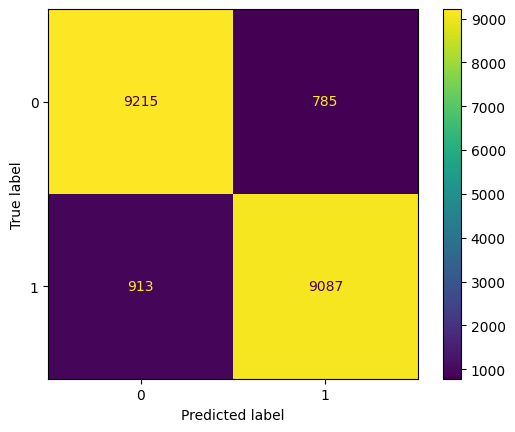

In [ ]:
cm = confusion_matrix(img_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

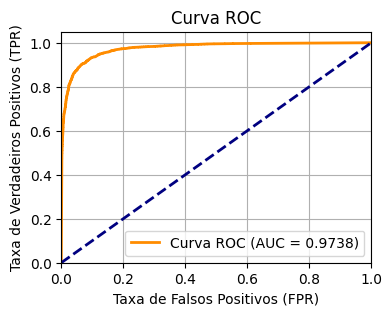

In [ ]:
y_score = knn.predict_proba(resnet_test)[:, 1]

fpr, tpr, thresholds = roc_curve(img_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
resnet_scores = [
    round(accuracy_score(img_test['label'], y_pred), 4),
    round(precision_score(img_test['label'], y_pred), 4),
    round(recall_score(img_test['label'], y_pred), 4),
    round(f1_score(img_test['label'], y_pred), 4),
    round(roc_auc_score(img_test['label'], knn.predict_proba(resnet_test)[:, 1]), 4)
]

##Teste de Wilcoxon para dados pareados

In [ ]:
print("color_scores:", color_scores)
print("haralick_scores:", haralick_scores)
print("resnet_scores:", resnet_scores)

color_scores: [0.7683, 0.7874, 0.7351, 0.7603, 0.8514]
haralick_scores: [0.8262, 0.8197, 0.8363, 0.8279, 0.9043]
resnet_scores: [0.9151, 0.9205, 0.9087, 0.9146, 0.9738]


In [ ]:
from scipy.stats import wilcoxon
print('color x haralick:', wilcoxon(haralick_scores, color_scores, alternative='greater'))
print('color x resnet:', wilcoxon(resnet_scores, color_scores, alternative='greater'))
print('haralick x resnet:', wilcoxon(resnet_scores, haralick_scores, alternative='greater'))

color x haralick: WilcoxonResult(statistic=15.0, pvalue=0.03125)
color x haralick: WilcoxonResult(statistic=15.0, pvalue=0.03125)
haralick x resnet: WilcoxonResult(statistic=15.0, pvalue=0.03125)
